# Calibration of PreScan Standard Camera


In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

%matplotlib qt



In [1]:
### TODO:
# 1. Count nx and ny
# 2. Convert color image to grayscale
# 3. Get corners


import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt


# prepare object points
nx = 7#TODO: enter the number of inside corners in x
ny = 5#TODO: enter the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('ps/*1.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(5)

cv2.destroyAllWindows()


In [3]:
###


%matplotlib inline

# Test undistortion on an image
img = cv2.imread('./post_calib/0000.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('output_images/calibration3_test_undist.jpg', dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["objpoints"] = objpoints
dist_pickle["imgpoints"] = imgpoints
pickle.dump( dist_pickle, open( "ps/wide_dist_pickle.p", "wb" ) )


NameError: name 'objpoints' is not defined

In [3]:
mtx

array([[  9.54290452e+02,   0.00000000e+00,   4.72288961e+02],
       [  0.00000000e+00,   1.00980195e+03,   3.55183968e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [4]:
dist

array([[-0.32671203,  0.7264075 ,  0.00803299,  0.0466595 , -1.31759551]])

[[  1.12500000e+03   0.00000000e+00   4.80000000e+02]
 [  0.00000000e+00   1.12500000e+03   3.60000000e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ 0.  0.  0.  0.  0.]]


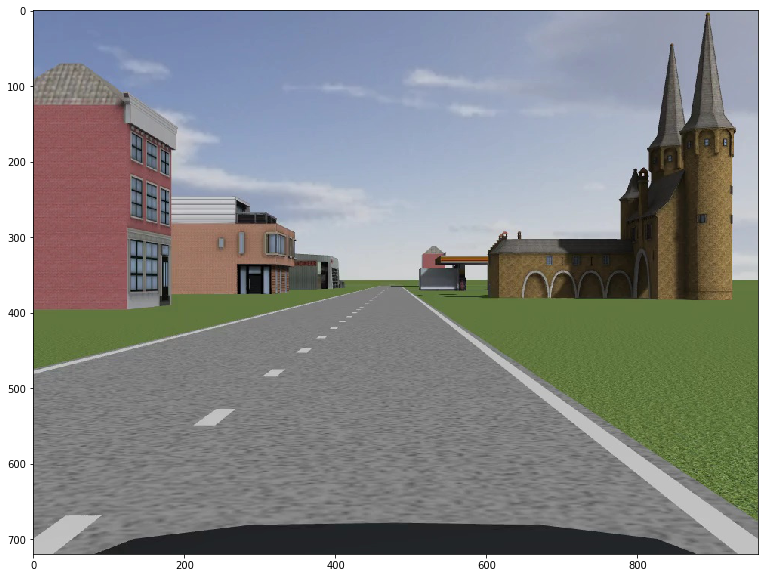

In [4]:
%matplotlib inline

# Test undistortion on an image
img = mpimg.imread('./post_calib/0000.jpg')
img_size = (img.shape[1], img.shape[0])

# Ideal parameters
mtx = np.array([[  1125.0,   0.00000000e+00,   480],
       [  0.00000000e+00,   1125.0,   360],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])
print(mtx)
dist = np.array([[0.0, 0, 0, 0, 0]])
print(dist)

plt.figure(figsize=(20,10))
plt.imshow(img)

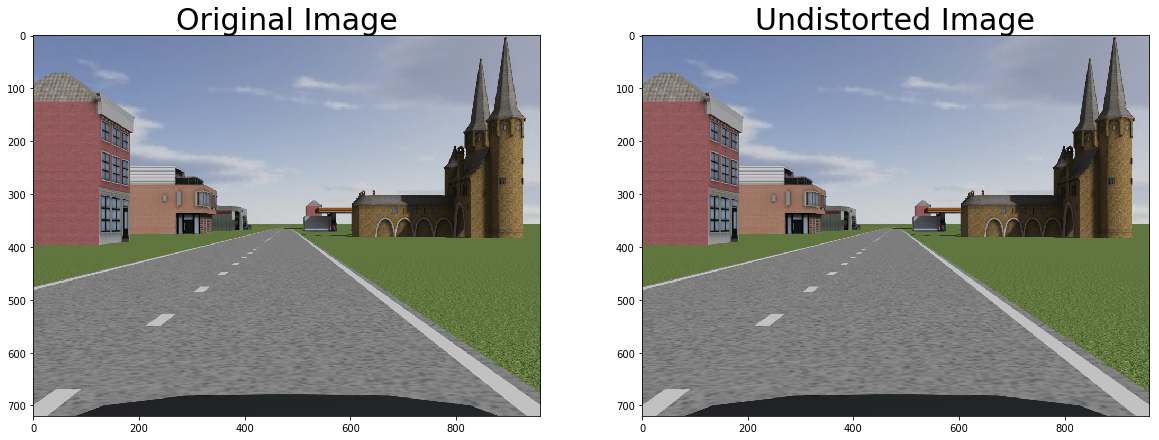

In [5]:
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


720 960


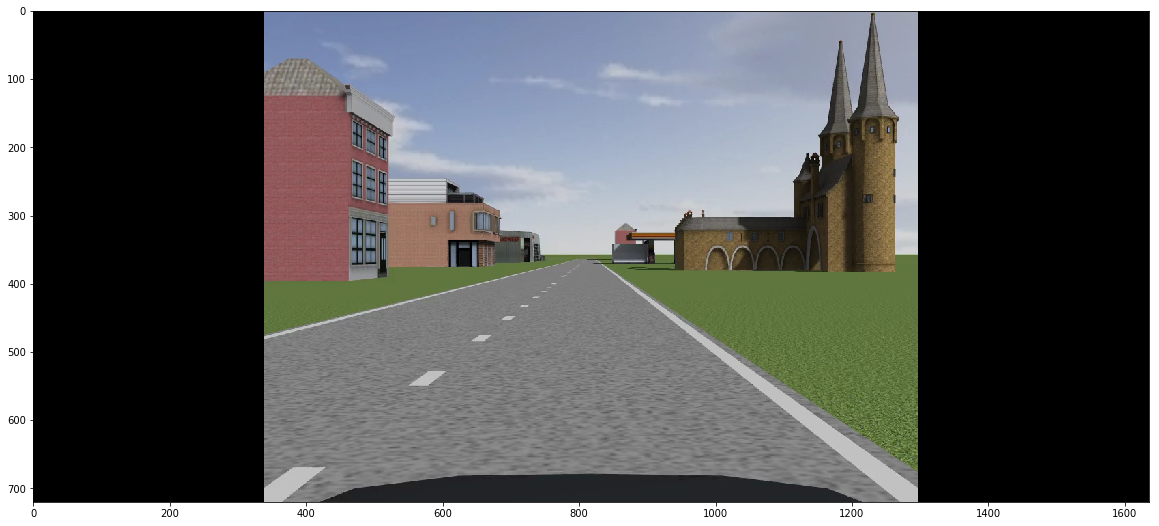

In [9]:
height = img.shape[0]
width = img.shape[1]

print(height, width)

ew = 338
v2 = 434.25
u2 = 331.25

Width = width+2*ew

IM = np.zeros((height, width+2*ew,3), np.uint8)
for i in range(width):
    IM[:, ew+i, :] = img[:,i,:]

plt.figure(figsize=(20,10))
plt.imshow(IM)

[[ -1.00322095e+00  -2.27940928e+00   1.63889527e+03]
 [ -1.55431223e-15  -2.52428998e+00   1.09364863e+03]
 [ -2.16840434e-18  -2.78612093e-03   1.00000000e+00]]


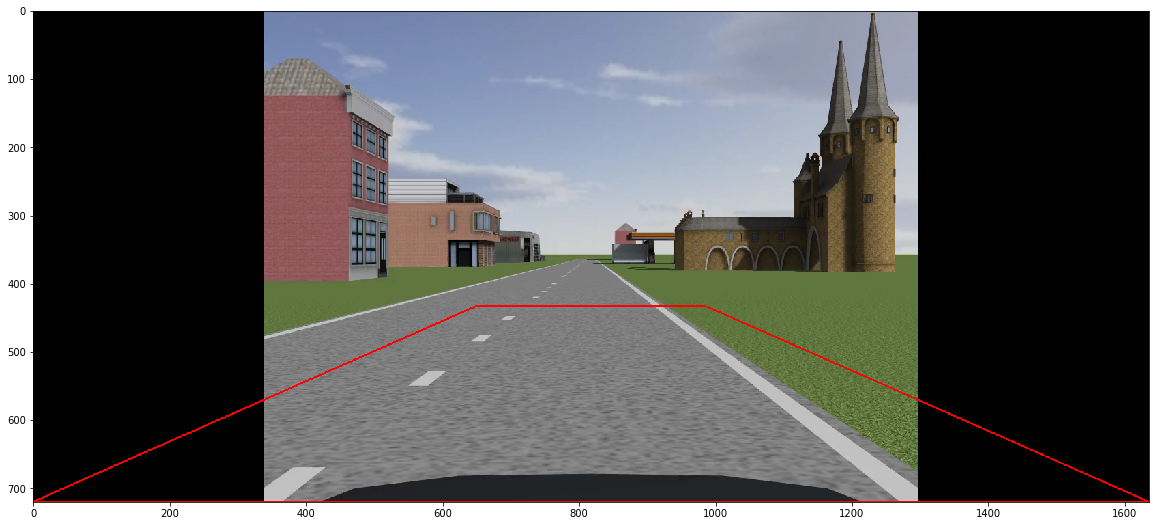

In [10]:

# Set the view of perspective
pts_list = [[0,height-1],[ew+u2-20, v2-1], [ew+width-u2+20,v2-1], [width+2*ew-1,height-1]]
pts_list_dst = [[0,height-1],[0,0],[Width-1,0],[Width-1,height-1]]
pts = np.array(pts_list, np.int32)
pts = pts.reshape((-1,1,2))
tmp = np.copy(IM)

# Draw the ROI on the image
cv2.polylines(tmp,[pts],True,(255,0,0), thickness=2)
plt.figure(figsize=(20,10))
plt.imshow(tmp)

points_src = np.float32(pts_list)
points_dst = np.float32(pts_list_dst)

M = cv2.getPerspectiveTransform(points_src, points_dst)
Minv = cv2.getPerspectiveTransform(points_dst, points_src)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["M"] = M
dist_pickle["Minv"] = Minv
pickle.dump( dist_pickle, open( "cam_pickle.p", "wb" ) )

print(M)

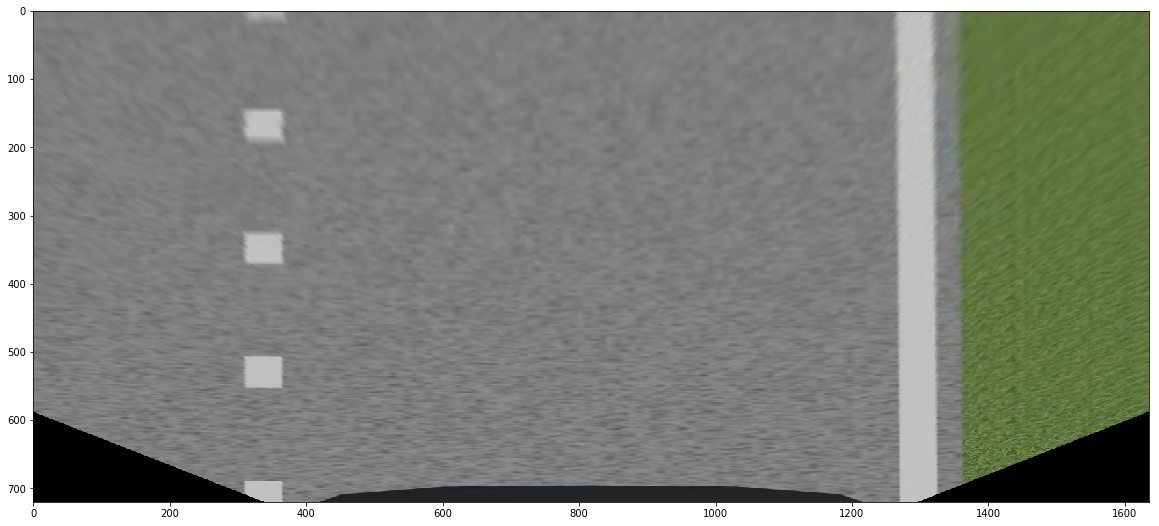

In [11]:
warped = cv2.warpPerspective(IM, M, (IM.shape[1], IM.shape[0]))

plt.figure(figsize=(20,10))
plt.imshow(warped)


In [49]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    # average coordinates of line segments
    x_l = []
    y_l = []
    x_r = []
    y_r = []
    # weights based on length
    w_l = []
    w_r = []
    # intersections
    b_l = []
    b_r = []
    # slope
    k_l = []
    k_r = []
    # upper endpoint
    y_min_l = 539
    y_min_r = 539

    for line in lines:
        for x1, y1, x2, y2 in line:
            L = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            k = (y2 - y1)/(x2 - x1)
            b = y1 - k * x1
            if k>0:# right parts
                x_r.append((x1+x2)/2.0)
                y_r.append((y1+y2)/2.0)
                w_r.append(L)
                b_r.append(b)
                k_r.append(k)

                if y_min_r > y1:
                    y_min_r = y1

                if y_min_r > y2:
                    y_min_r = y2
            else:# left parts
                x_l.append((x1+x2)/2.0)
                y_l.append((y1+y2)/2.0)
                w_l.append(L)
                b_l.append(b)
                k_l.append(k)

                if y_min_l > y1:
                    y_min_l = y1

                if y_min_l > y2:
                    y_min_l = y2
            #print( k, L)
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    # cost
    cost_l = 1e9
    cost_r = 1e9

    # Get lane line
    for i in range(len(b_l)):
        # calculate distance of each (k,b)
        dist = distance(k_l[i], b_l[i], x_l, y_l, w_l)

        if cost_l > dist:
            cost_l = dist
            m_l = k_l[i]
            c_l = b_l[i]
    # plot on the image
    cv2.line(img, (math.floor((539-c_l)/m_l), 539), (math.floor((y_min_l-c_l)/m_l), y_min_l), color, thickness)

    # Get right lane line
    for i in range(len(b_r)):
        dist = distance(k_r[i], b_r[i], x_r, y_r, w_r)
        if cost_r > dist:
            cost_r = dist
            m_r = k_r[i]
            c_r = b_r[i]

    cv2.line(img, (math.floor((539-c_r)/m_r), 539), (math.floor((y_min_r-c_r)/m_r), y_min_r), color, thickness)


def distance(k,b,x,y,l):
    """
    k and b is the  objective line. x, y, and l are all the lines.
    
    Returns the weighted distance of the objective line
    """
    
    s = 0
    for i in range(len(x)):
        # compute weighted cost
        # (x0，y0) to ax + by +c = 0 is abs(a*x0+b*y0+c)/sqr(a**2+b**2)
        s += l[i]*math.fabs(k*x[i]+b-y[i])/math.sqrt(1 +  k**2)
    return s

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

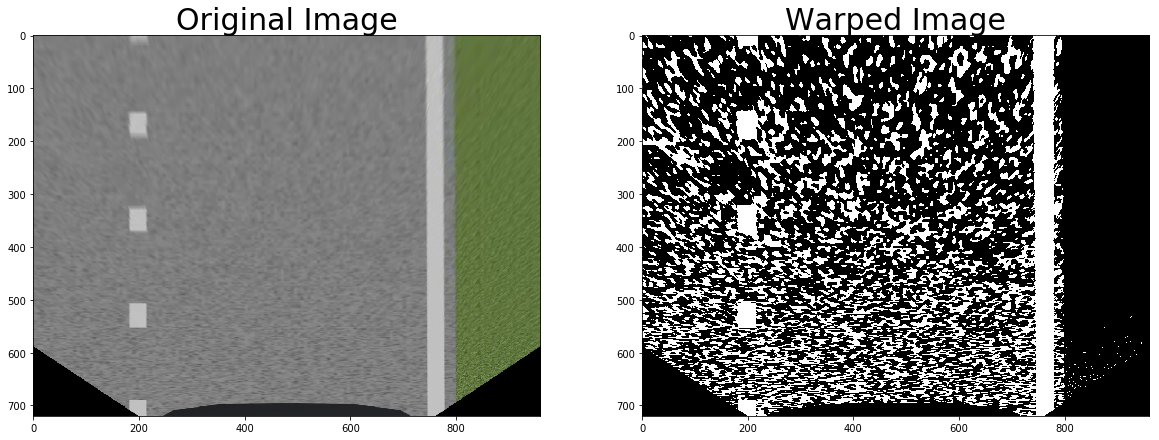

In [69]:
gray = grayscale(warped)

#th3 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#            cv2.THRESH_BINARY,11,2)

ret,th3 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(warped)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(th3, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)


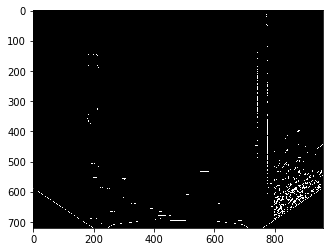

In [70]:

# Define a kernel size and apply Gaussian smoothing
kernel_size = 1
blur_gray = gaussian_blur(gray, kernel_size)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 3*low_threshold
edges = canny(blur_gray, low_threshold, high_threshold)

plt.imshow(edges, cmap='gray')

/home/dev2/miniconda3/envs/env-changjie/lib/python3.5/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in int_scalars
/home/dev2/miniconda3/envs/env-changjie/lib/python3.5/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in double_scalars


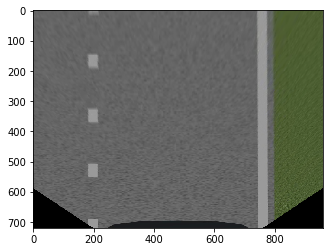

In [57]:
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 5     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 8 #minimum number of pixels making up a line
max_line_gap = 5    # maximum gap in pixels between connectable line segments
line_image = np.copy(warped)*0 # creating a blank to draw lines on

# This time we are defining a four sided polygon to mask
imshape = warped.shape
vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[0],0), (imshape[1],imshape[0])]], dtype=np.int32)
masked_img = region_of_interest(edges, vertices)

lines = hough_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap)

output_im = weighted_img(lines,warped)

plt.imshow(output_im)

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from detector import Detector, print_prof_data
%matplotlib inline


dist_pickle = pickle.load( open( "cam_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M = dist_pickle["M"]
Minv = dist_pickle["Minv"]

detector = Detector(mtx=mtx, dist=dist, M=M, Minv=Minv, sx_thresh=(20,100), s_thresh=(170,255))
# Set number of buffers
detector.LeftLine.N = 5
detector.RightLine.N = 5
# Parameters of Kalman filter. KF is not adoppted here and forget those parameters
q=[10, 10, 20]
R=[1, 1, 1]
detector.setKF_PR(q, R)
# Set margins
detector.setMargin(60)
# Set color transforms
detector.setBinaryFun(flag=5)
# Turn off Kalman filter
detector.switchKF(False)

In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output/project_output_v2_kf.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("./project_video.mp4").subclip(20,45)
clip1 = VideoFileClip("./extendedOutput.avi").subclip(0,10)

#clip1 = VideoFileClip("./challenge_video.mp4").subclip(0,3)
#white_output = 'output_images/challenge_output_1.mp4'
#clip1 = VideoFileClip("./harder_challenge_video.mp4").subclip(0,2)
#white_output = 'output_images/harder_challenge_output_1.mp4'

white_clip = clip1.fl_image(detector.detect) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output/project_output_v2_kf.mp4
[MoviePy] Writing video output/project_output_v2_kf.mp4


100%|█████████▉| 300/301 [00:38<00:00,  7.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_output_v2_kf.mp4 

CPU times: user 1min 24s, sys: 2.13 s, total: 1min 26s
Wall time: 39 s


In [4]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))